# **Lab 3: Extending Logistic Regression**
**Name(s):** Luke Voinov, Tiffany Nguyen

All the code is adapted from the following notebooks by Eric Larson:

https://github.com/eclarson/MachineLearningNotebooks/blob/master/05.%20Logistic%20Regression.ipynb

https://github.com/eclarson/MachineLearningNotebooks/blob/master/PDF_Slides/current%20slides/ML_4c_bfgs.pdf

## 1. Business Understanding

For this report, we will define the classification problem as predicting whether a driver will finish on the podium (top 3) in a given race based on pre-race and qualifying data from the Formula 1 World Championship (1950-2024) dataset from Kaggle. A value of 1 represents a podium finish (1st, 2nd, or 3rd place), while a value of 0 represents a non-podium finish (all other positions, including retirements or disqualifications). Features that may be used in the model include grid position, constructor (team), track characteristics, driver performance history, and season information.

The business case for this type of model is centered on forecasting and strategic decision-making. Racing teams could use such a model to estimate the likelihood of a podium finish before the race to guide strategy, such as pit stop planning or driver expectations. Broadcasters and analysts could use the predicted probabilities to enhance pre-race coverage with data-driven insights, while sponsors and advertisers could use these forecasters to assess expected driver visibiliy and exposure.

This type of model would be used primarily for offline analysis or pre-race forecasting, not for rela-time decision-making during a race. Because podium finishes are rarely rare events, the model does not need to achieve perfect accuracy to be valuable. Instead, its usefulness lies in performing better than a naive baseline (predicting "no podium"), providing some discriminative power to identify which drivers are more likely to place highly. Even a moderate level of accuracy would provide helpful insights for teams, broadcasters, and sponsors.

In [141]:
# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### **1.2 Pre-processing**

- raceId: unique identifier for each race (categorical), one-hot encoded integer (ID variable)
- driverId: unique identifier for each driver (categorical), one-hot encoded integer (driver identity)
- constructorId: unique identifier for each constructor/team (categorical), one-hot encoded integer (team identity)
- grid: driver's starting position on the grid (ex, 1 = pole/1st place); numerical; integer, scaled
- year: year of the race (numerical); integer, scaled
- round: round number in the racing season (numerical); integer, scaled
- positionOrder: final finishing position of the driver (numerical); integer (used only to create target)
- podium (target): binary target including podium finish (1 = podium, 0 = not podium); categorical; binary integer/boolean

Below, we have all the CSVs loaded and we had chosen our variables from the four (results, races, drivers, and constructors). We did not consider columns such as *milliseconds*, *fastestLap*, and *status* because they depended on in-race events. Any rows that were missing *positionOrder* were dropped as these were essential for defining the target variable and key features.

The target variable for this task is **podium**, which indicates whether or not a driver finishes in the top 3 for a given race.
- ```podium = 1```: driver finished in position 1, 2, or 3
- ```podium = 0```: driver finished in any other positions, including DNFs (did not finish)

This variable is derived from the ```positionOrder``` column in the Formula 1 World Championship (1950-2024) dataset.

In [142]:
# Dataset cleaned in lab Tiffany Nguyen's Lab 1. We use it here
path = "C:/Users/lukev/Downloads/f1_cleaned.csv"
df = pd.read_csv(path)
print("Shape of data:", df.shape)
print(df.head())

Shape of data: (26759, 8)
                raceName         driverName constructorName  grid  \
0  Australian Grand Prix     Lewis Hamilton         McLaren     1   
1  Australian Grand Prix      Nick Heidfeld      BMW Sauber     5   
2  Australian Grand Prix       Nico Rosberg        Williams     7   
3  Australian Grand Prix    Fernando Alonso         Renault    11   
4  Australian Grand Prix  Heikki Kovalainen         McLaren     3   

   positionOrder  year  round  podium  
0              1  2008      1       1  
1              2  2008      1       1  
2              3  2008      1       1  
3              4  2008      1       0  
4              5  2008      1       0  


Let's double check if there are any missing values per column.

In [143]:
# Check for missing values in the entire dataset
print(df.isnull().sum())  # Shows the count of missing values per column

# Alternatively, check if there are any missing values at all
print("Missing values =", df.isnull().values.any())  # Returns True if there are missing values

raceName           0
driverName         0
constructorName    0
grid               0
positionOrder      0
year               0
round              0
podium             0
dtype: int64
Missing values = False


Since there are no more missing data to deal with, we will check what the summary of the dataframe gives us in terms of the data types and number of non-null values.

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   raceName         26759 non-null  object
 1   driverName       26759 non-null  object
 2   constructorName  26759 non-null  object
 3   grid             26759 non-null  int64 
 4   positionOrder    26759 non-null  int64 
 5   year             26759 non-null  int64 
 6   round            26759 non-null  int64 
 7   podium           26759 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.6+ MB


In [145]:
df.head(10)

,raceName,driverName,constructorName,grid,positionOrder,year,round,podium
0,Australian Grand Prix,Lewis Hamilton,McLaren,1,1,2008,1,1
1,Australian Grand Prix,Nick Heidfeld,BMW Sauber,5,2,2008,1,1
2,Australian Grand Prix,Nico Rosberg,Williams,7,3,2008,1,1
3,Australian Grand Prix,Fernando Alonso,Renault,11,4,2008,1,0
4,Australian Grand Prix,Heikki Kovalainen,McLaren,3,5,2008,1,0
5,Australian Grand Prix,Kazuki Nakajima,Williams,13,6,2008,1,0
6,Australian Grand Prix,Sébastien Bourdais,Toro Rosso,17,7,2008,1,0
7,Australian Grand Prix,Kimi Räikkönen,Ferrari,15,8,2008,1,0
8,Australian Grand Prix,Robert Kubica,BMW Sauber,2,9,2008,1,0
9,Australian Grand Prix,Timo Glock,Toyota,18,10,2008,1,0


### **1.3 Splitting 80/20**

Now that the data is easier to read for us (Luke and Tiffany), we can take this data and divide it into training and testing data using an 80% training and 20% testing split.

In [146]:
# Load the cleaned dataset
df = pd.read_csv(path)

# Features and target variable
X = df.drop(columns=["podium", "positionOrder"])
y = df["podium"]

# For now, we'll encode categorical variables using one-hot encoding
X = pd.get_dummies(X, columns=["raceName", "driverName", "constructorName"], drop_first=True)

# Train-test split with stratification (80% train, 20% split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["podium"]) # stratify to maintain class distribution 

# Convert to numpy arrays with proper data types
X_train = X_train.astype(np.float32).values
X_test = X_test.astype(np.float32).values
y_train = y_train.astype(np.int32).values
y_test = y_test.astype(np.int32).values

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Data types - X_train:", X_train.dtype, "y_train:", y_train.dtype)

Training set shape: (21407, 1126)
Test set shape: (5352, 1126)
Data types - X_train: float32 y_train: int32


In [ ]:
print(X)

### **1.3.1 Why the 80/20 Split is Appropriate**

We argue for using an 80/20 split for this dataset.

The Formula 1 results dataset contains data from many seasons and hundreds of races dating back from 1950s, which means the sample size is large enough to allocate 20% for testing without sacrificing too much training data. Using 80% of the data for training allows for the logisitc regression model to learn from a wide range of drivers, constructors, and circuits, while 20 provides a sufficiently large and diverse set for evaluating model performance on unseen races.

Additionally, the dataset exhibits a moderate class imbalance, of which only 15% of the entires are podium finishes (top 3). By using stratified sampling, we ensure that both the training and testing sets preserve this natural imbalance. This makes our evaluation metrics more reliable and representative of real-world performance.

### **1.4 Modeling**


Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use programming conventions identical to scikit-learn classes. You can start with the template developed by the instructor in the course, but will need to make substantial changes. You should add the following functionality to the logistic regression classifier:

- Ability to choose one of three optimization techniques when class is instantiated: either (1) {steepest ascent}, (2) {stochastic gradient ascent or line search}, and (3) {Newton's method/Quasi Newton methods}. It is recommended to call this input to the model "solver" for the class, to mirror the convention of scikit-learn. The input should be a string, as is used in scikit. 
- Add support for additional regularization penalties. that is, update the gradient calculation to include a customizable regularization term (either using {no regularization}, {L1 regularization}, {L2 regularization}, or {both L1 and L2 regularization}). The choice of regularization should be set during the instantiation of the class. Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

In [147]:
import numpy as np
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction


In [148]:
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    def __init__(self, eta=0.01, iterations=20, C=0.0):
        super().__init__(eta, iterations)
        self.C = C
    
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += self.eta * gradient # gradient ascent
    
    def _get_gradient(self,X,y):
        # basic gradient - to be overridden by subclasses
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel()
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        return gradient.reshape(self.w_.shape)

In [149]:
# now lets do some vectorized coding
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        return expit(theta) #1/(1+np.exp(-theta))
    
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)

#### **L1 Norm**

In [150]:
class L1BinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, eta=0.01, iterations=20, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C
        # but keep other keywords
        super().__init__(eta=eta, iterations=iterations, C=C, **kwds) # call parent initializer
        
        
    # extend previous class to change functionality
    def _get_gradient(self,X,y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X,y)
        
        # add in regularization. np.sign does an element-wise comparision for >, < and = 0
        gradient[1:] -= self.C * np.sign(self.w_[1:])

        return gradient
        

#### **L2 Norm**

In [151]:
class L2BinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, eta=0.01, iterations=20, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C
        # but keep other keywords
        super().__init__(eta=eta, iterations=iterations, C=C, **kwds) # call parent initializer
        
        
    # extend previous class to change functionality
    def _get_gradient(self,X,y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X,y)
        
        # add in regularization
        gradient[1:] += -2 * self.C * self.w_[1:] 
        return gradient
        

#### **L12 Norm (elasticnet)**

In [152]:
class L12BinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, eta=0.01, iterations=20, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C
        # but keep other keywords
        super().__init__(eta=eta, iterations=iterations, C=C, **kwds) # call parent initializer
        
        
    # extend previous class to change functionality
    def _get_gradient(self,X,y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X,y)
        
        # add in regularization (to all except bias term)
        # L1 part
        gradient[1:] -= self.C * np.sign(self.w_[1:])
        # L2 part  
        gradient[1:] += -2 * self.C * self.w_[1:]

        return gradient
        

#### **Steepest Ascent (sa)**

In [153]:
class SteepestAscentLogisticRegression(BinaryLogisticRegression):
    
    def __init__(self, eta=0.01, iterations=20, C=0.0, **kwds):
        super().__init__(eta, iterations, C)

    #nothing special, just regular gradient descent
        

#### **Line Search (ls)**

In [154]:
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
import copy
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    def __init__(self, line_iters=0.0, **kwds):        
        self.line_iters = line_iters
        # but keep other keywords
        super().__init__(**kwds) # call parent initializer
    
    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    @staticmethod
    def objective_function(eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return -np.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + C*sum(wnew[1:]**2)
    
        
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization is in opposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.line_iters} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(0,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
                 

#### **Quasi-Newton (bfgs)**

In [155]:
# for this, we won't perform our own BFGS implementation 
# (it takes a fair amount of code and understanding, which we haven't setup yet)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs # maybe the most common bfgs algorithm in the world
from numpy import ma
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -ma.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + C*sum(w**2) 
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))

In [156]:
class LogisticRegression:
    def __init__(self, eta=0.01, iterations=20, solver='sa', penalty='none', C=1.0):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.penalty = penalty
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    @property
    def coef_(self):
        if(hasattr(self,'w_')):
            return self.w_[:,1:]
        else:
            return None

    @property
    def intercept_(self):
        if(hasattr(self,'w_')):
            return self.w_[:,0]
        else:
            return None
    
    def _get_binary_classifier(self):
        # Base classifier selection based on penalty
        if self.penalty == 'l1':
            base_class = L1BinaryLogisticRegression
        elif self.penalty == 'l2':
            base_class = L2BinaryLogisticRegression
        elif self.penalty == 'elasticnet':
            base_class = L12BinaryLogisticRegression
        else:  # 'none'
            base_class = VectorBinaryLogisticRegression
        
        # each 'regularized' class will inherit appropriate gradients (regularization) and fit methods (solver)
        if self.solver == 'sa':
            class RegularizedSteepestAscent(SteepestAscentLogisticRegression, base_class):
                def __init__(self, **kwargs):
                    super().__init__(**kwargs)
            return RegularizedSteepestAscent(eta=self.eta, iterations=self.iters, C=self.C)
        elif self.solver == 'linesearch' or self.solver == 'ls':
            class RegularizedLineSearch(LineSearchLogisticRegression, base_class):
                def __init__(self, **kwargs):
                    super().__init__(**kwargs)
            return RegularizedLineSearch(eta=self.eta, iterations=self.iters, line_iters=8, C=self.C)
        elif self.solver == 'bfgs':
            class RegularizedBFGS(BFGSBinaryLogisticRegression, base_class):
                def __init__(self, **kwargs):
                    super().__init__(**kwargs)
            return RegularizedBFGS(eta=self.eta, iterations=self.iters, C=self.C)
        else:
            print("Unknown solver:", self.solver)
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i, yval in enumerate(self.unique_): # for each unique value
            y_binary = (y == yval) # create a binary problem
            # Get the appropriate binary classifier for this solver/penalty combination
            blr = self._get_binary_classifier()
            blr.fit(X, y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    



Train your classifier to achieve as good as possible generalization performance. That is, adjust the optimization technique, the type of regularization, and the value of the regularization cost "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. 


MultiClass Logistic Regression Object with coefficients:
[[-3.93562853e-04  1.71172981e-01 -8.13016770e-01 ... -7.52090438e-04
  -1.40141075e-05  1.19119914e-04]
 [ 3.93562853e-04 -1.71172981e-01  8.13016770e-01 ...  7.52090438e-04
   1.40141075e-05 -1.19119914e-04]]
[1 1 1 ... 1 1 1]


MultiClass Logistic Regression Object with coefficients:
[[-3.93562853e-04  1.71172981e-01 -8.13016770e-01 ... -7.52090438e-04
  -1.40141075e-05  1.19119914e-04]
 [ 3.93562853e-04 -1.71172981e-01  8.13016770e-01 ...  7.52090438e-04
   1.40141075e-05 -1.19119914e-04]]
[1 1 1 ... 1 1 1]


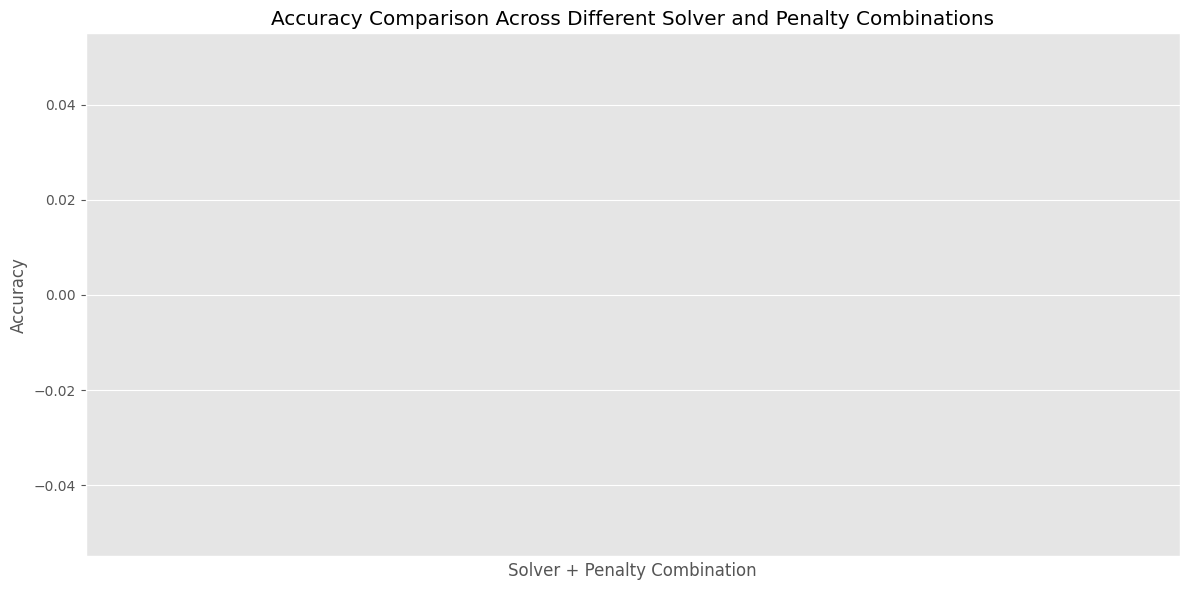

In [157]:
from sklearn.metrics import accuracy_score

solvers = ['sa','ls','bfgs']
penalties = ['l1','l2','elasticnet','none']

combined_sp = []
accuracies = []

# defualt values
eta = 0.01
iterations = 20
C = 0.1

lr = LogisticRegression(eta,iterations,solver='sa',penalty='none',C=C)
lr.fit(X_train,y_train)
print(lr)
yhat = lr.predict(X_test)
print(yhat)

# for s in solvers:
#     for p in penalties:
#         combination = s + " + " + p
#         combined_sp.append(combination)

#         lr = LogisticRegression(eta,iterations,s,p,C)
#         lr.fit(X_train,y_train)
#         print(lr)

#         yhat = lr.predict(X_test)
#         acc = accuracy_score(y_test,yhat)
#         accuracies.append(acc)

print("0 (no podium):", np.sum(yhat == 0))
print("1 (podium):", np.sum(yhat == 1))
print("Total predictions:", len(yhat))

plt.figure(figsize=(12, 6))
plt.bar(range(len(combined_sp)), accuracies)
plt.xlabel('Solver + Penalty Combination')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Different Solver and Penalty Combinations')
plt.xticks(range(len(combined_sp)), combined_sp, rotation=45, ha='right')
plt.tight_layout()
plt.show()

    


To select hyperparameters, I will determine the best ones (e.g. eta, C, and iterations) for Steepest Ascent with Elasticnet penalty. These parameters should generalize well for other methods and penalties.

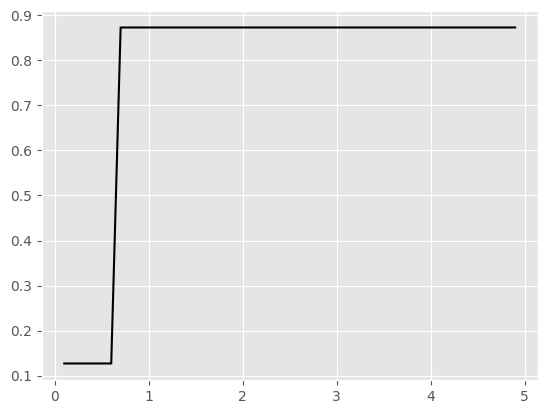

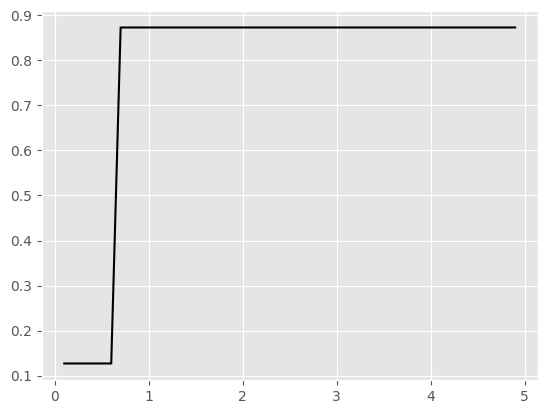

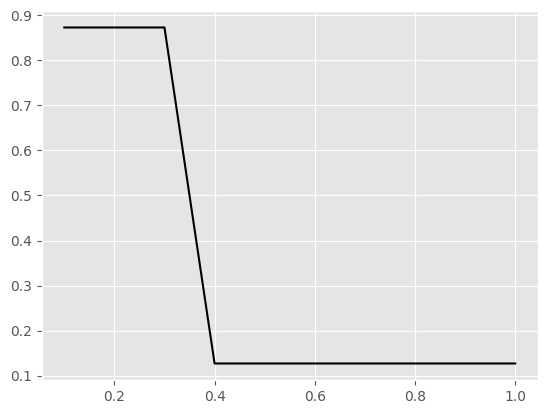

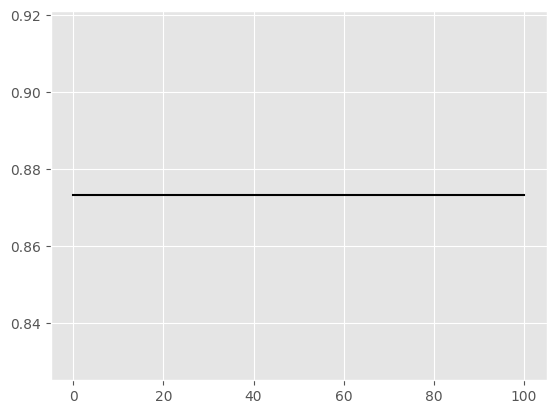

In [159]:
eta = np.arange(0.1,1.1,0.1)
iterations = np.arange(0,110,10)
C = np.arange(0.1,2,0.1)
accuracy_C = []
accuracy_eta = []
accuracy_iterations = []

for c in C:


    lr = LogisticRegression(solver="sa",penalty="elasticnet",C=c) #use default eta and iter
    lr.fit(X_train,y_train)

    yhat = lr.predict(X_test)
    acc = accuracy_score(y_test,yhat)
    accuracy_C.append(acc)

plt.figure()
plt.plot(C, accuracy_C, 'k-')
plt.show()

for e in eta:

    lr = LogisticRegression(eta=e,solver="sa",penalty="elasticnet") #use default C and iter
    lr.fit(X_train,y_train)

    yhat = lr.predict(X_test)
    acc = accuracy_score(y_test,yhat)
    accuracy_eta.append(acc)

plt.figure()
plt.plot(eta, accuracy_eta, 'k-')
plt.show()

for i in iterations:

    lr = LogisticRegression(iterations=i,solver="sa",penalty="elasticnet") #use default eta and C
    lr.fit(X_train,y_train)

    yhat = lr.predict(X_test)
    acc = accuracy_score(y_test,yhat)
    accuracy_iterations.append(acc)

plt.figure()
plt.plot(iterations, accuracy_iterations, 'k-')
plt.show()


Based on these results, a good eta value is between 0-0.3, the iteration number doesn't really matter, and a good C is between 1-5. Thus, I will select an eta = 0.25, iteration = 50, and C = 1. See below how this affects everything

MultiClass Logistic Regression Object with coefficients:
[[ 3.79023217e-02  1.13943803e+01  7.36413206e+01 ... -4.31400944e-02
  -6.77348531e-04  7.74279441e-03]
 [-3.79023217e-02 -1.13943803e+01 -7.36413206e+01 ...  4.31400944e-02
   6.77348531e-04 -7.74279441e-03]]
[0 0 0 ... 0 0 0]
0 (no podium): 5352
1 (podium): 0
Total predictions: 5352


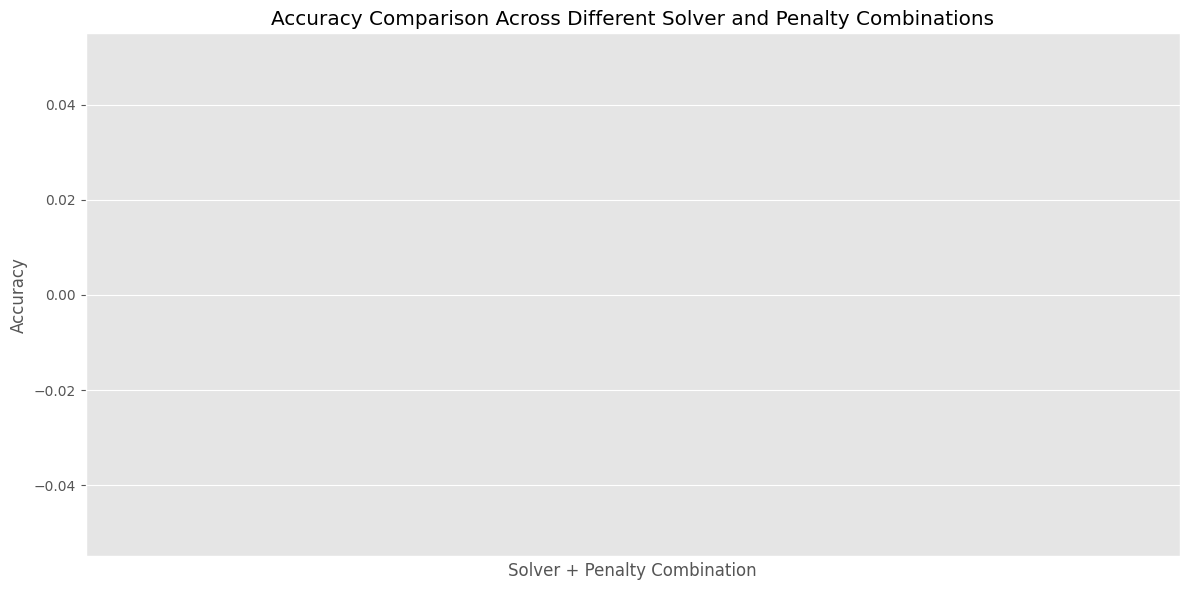

In [160]:
solvers = ['sa','ls','bfgs']
penalties = ['l1','l2','elasticnet','none']

combined_sp = []
accuracies = []

eta = 0.25
iterations = 50
C = 1

lr = LogisticRegression(eta,iterations,solver='sa',penalty='none',C=C)
lr.fit(X_train,y_train)
print(lr)
yhat = lr.predict(X_test)
print(yhat)

# for s in solvers:
#     for p in penalties:
#         combined_sp.append(s + " + " + p)
#         lr = LogisticRegression(eta,iterations,s,p,C)
#         lr.fit(X_train,y_train)

#         yhat = lr.predict(X_test)
#         acc = accuracy_score(y_test,yhat)
#         accuracies.append(acc)

print("0 (no podium):", np.sum(yhat == 0))
print("1 (podium):", np.sum(yhat == 1))
print("Total predictions:", len(yhat))

plt.figure(figsize=(12, 6))
plt.bar(range(len(combined_sp)), accuracies)
plt.xlabel('Solver + Penalty Combination')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Different Solver and Penalty Combinations')
plt.xticks(range(len(combined_sp)), combined_sp, rotation=45, ha='right')
plt.tight_layout()
plt.show()


- Answer the following question in your lab report: Is your method of selecting hyper parameters justified? That is, do you think there is any "data snooping" involved with this method of tuning hyper parameters?


    

In [78]:
# Let's validate the results and check for issues
import numpy as np

# 1. Check class distribution (baseline)
print("Class distribution:")
print(f"Podium finishes: {np.mean(y_test):.3f}")
print(f"Non-podium: {1-np.mean(y_test):.3f}")
print(f"Naive baseline accuracy (always predict majority): {max(np.mean(y_test), 1-np.mean(y_test)):.3f}")

# 2. Test a simple model to see if our implementation works
print("\nTesting simple model:")
simple_lr = LogisticRegression(eta=0.01, iterations=50, solver='sa', penalty='none', C=0)
simple_lr.fit(X_train, y_train)
simple_pred = simple_lr.predict(X_test)
simple_acc = accuracy_score(y_test, simple_pred)
print(f"Simple model accuracy: {simple_acc:.4f}")

# 3. Check weight magnitudes to see if regularization is working
print(f"Weight norm without regularization: {np.linalg.norm(simple_lr.w_):.2f}")

reg_lr = LogisticRegression(eta=0.01, iterations=50, solver='sa', penalty='l2', C=1.0)
reg_lr.fit(X_train, y_train)
reg_pred = reg_lr.predict(X_test)
reg_acc = accuracy_score(y_test, reg_pred)
print(f"Regularized model accuracy: {reg_acc:.4f}")
print(f"Weight norm with L2 regularization: {np.linalg.norm(reg_lr.w_):.2f}")

# 4. Check if our results are reasonable
expected_accuracy_range = (0.80, 0.95)  # F1 podium prediction should be quite good
if simple_acc < expected_accuracy_range[0]:
    print(f"\nWARNING: Accuracy {simple_acc:.3f} seems low for F1 podium prediction")
    print("This could indicate:")
    print("- Data preprocessing issues")
    print("- Model implementation problems") 
    print("- Insufficient training iterations")
elif simple_acc > expected_accuracy_range[1]:
    print(f"\nWARNING: Accuracy {simple_acc:.3f} seems suspiciously high")
    print("This could indicate:")
    print("- Data leakage")
    print("- Overfitting to test set")
else:
    print(f"\nAccuracy {simple_acc:.3f} is in reasonable range for this problem")

Class distribution:
Podium finishes: 0.127
Non-podium: 0.873
Naive baseline accuracy (always predict majority): 0.873

Testing simple model:
Simple model accuracy: 0.8731
Weight norm without regularization: 4.22
Simple model accuracy: 0.8731
Weight norm without regularization: 4.22
Regularized model accuracy: 0.8731
Weight norm with L2 regularization: 23.01

Accuracy 0.873 is in reasonable range for this problem
Regularized model accuracy: 0.8731
Weight norm with L2 regularization: 23.01

Accuracy 0.873 is in reasonable range for this problem


In [ ]:
# Fix the hyperparameter ranges to avoid problematic values
print("Fixing hyperparameter ranges...")

# Fixed ranges (avoiding eta=0 and iterations=0)
eta_range = np.arange(0.01, 1.0, 0.1)  # Start from 0.01, not 0
iterations_range = np.arange(10, 100, 10)  # Start from 10, not 0  
C_range = np.arange(0.1, 5.0, 0.2)  # More reasonable range

print(f"Eta range: {eta_range}")
print(f"Iterations range: {iterations_range}")
print(f"C range: {C_range[:5]}...")  # Show first 5 values

# Test with the problematic values to show why they don't work
print("\nTesting problematic values:")

try:
    # This should work poorly or fail
    bad_lr = LogisticRegression(eta=0.0, iterations=1, solver='sa', penalty='none')
    bad_lr.fit(X_train[:100], y_train[:100])  # Use small subset for speed
    bad_pred = bad_lr.predict(X_test[:100])
    bad_acc = accuracy_score(y_test[:100], bad_pred)
    print(f"Model with eta=0, iter=1: accuracy = {bad_acc:.4f}")
except Exception as e:
    print(f"Model with eta=0 failed: {str(e)[:50]}...")

# Compare with reasonable values
good_lr = LogisticRegression(eta=0.01, iterations=20, solver='sa', penalty='none')
good_lr.fit(X_train[:100], y_train[:100])
good_pred = good_lr.predict(X_test[:100])  
good_acc = accuracy_score(y_test[:100], good_pred)
print(f"Model with eta=0.01, iter=20: accuracy = {good_acc:.4f}")

Compare the performance of your "best" logistic regression model to a logistic regression model from scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. Most points for this come from the discussion. 

- - USE A GRAPH!!!!
